In [4]:
# This is the initial take of pulling the MNIST CBIR from https://blog.sicara.com/keras-tutorial-content-based-image-retrieval-convolutional-denoising-autoencoder-dc91450cc511
#    and making it work in a Jupyter notebook for unrotated pill images.



In [5]:
import keras
keras.__version__

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'2.2.2'

In [6]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6472235168962197190
]


In [7]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [8]:
from keras import backend as K
#K.tensorflow_backend._get_available_gpus()

## Train model

In [18]:
target_image_size = (64,112)
target_image_size_3D = (64,112,1)

In [25]:
# Import required items for training
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D, Dense, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.callbacks import TensorBoard, EarlyStopping
from keras import callbacks
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
import numpy as np


# For training
# Import needed libraries
import numpy as np
from keras.models import Model
from keras.datasets import mnist
#import cv2
from keras.models import load_model
from sklearn.metrics import label_ranking_average_precision_score
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


In [15]:
def display_image(single_image):
    #check to see if image is rgb
    if (np.shape(single_image)[-1]==3):
        plt.imshow(single_image)
    if (np.shape(single_image)[-1]==1):
        si = np.concatenate((single_image,single_image,single_image), axis=2)
        plt.imshow(si)
        
def get_image(single_image):
    #check to see if image is rgb
    if (np.shape(single_image)[-1]==3):
        return single_image
    if (np.shape(single_image)[-1]==1):
        si = np.concatenate((single_image,single_image,single_image), axis=2)
        return si
    

In [32]:
# Load the data (in that case MNIST)
train_datagen = ImageDataGenerator(
        #shear_range=0.05,
        #zoom_range=0.01,
        #rotation_range=5.00,
        #height_shift_range=0.10,
        #width_shift_range=0.10,
        rescale=1. / 255,
        horizontal_flip=False)

validation_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
        'data_with_rotations/train',
        target_size=target_image_size,
        batch_size=16,
        class_mode='input',
        color_mode='grayscale')

validation_generator = validation_datagen.flow_from_directory(
        'data_with_rotations/validate',
        target_size=target_image_size,
        batch_size=32,
        class_mode='input',
        color_mode='grayscale')



Found 722 images belonging to 1 classes.
Found 191 images belonging to 1 classes.


Found 96 images belonging to 1 classes.
1


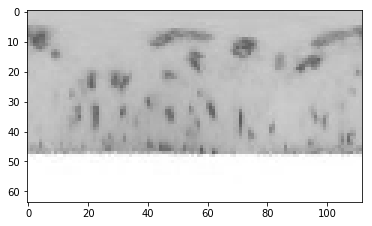

In [19]:
# Get 16 sample images to use throughout all the training for visualization
# Load Test images to generate testing data
sample_datagen = ImageDataGenerator(rescale=1. / 255)

sample_generator = sample_datagen.flow_from_directory(
        'data_with_rotations/test',
        target_size=target_image_size,
        batch_size=16,
        class_mode='input',
        color_mode='grayscale')

next_batch = next(sample_generator)
sample_images = next_batch[0]
test_image=sample_images[1]
ti = test_image

print(np.shape(ti)[-1])

display_image(test_image)

#test_display = np.concatenate((ti,ti,ti), axis=2)

#plt.imshow(test_display)

#plt.show()


In [14]:
len(test_image[:,:,0])
np.shape(sample_images)

(16, 64, 112, 1)

In [20]:
def define_model():
    
    big_conv = (7,7)
    num_conv = 128
    
    
    #Input
    input_img = Input(shape=target_image_size_3D, name='input')  # adapt this if using `channels_first` image data format
    
     # Layer 10
    x = Conv2D(16, (5, 5), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    # Layer 20
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
#    # Added
#    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#    x = MaxPooling2D((2, 2), padding='same')(x)
#    
#    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#    x = MaxPooling2D((2, 2), padding='same')(x)
     # Layer 30

 #   x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#    x = MaxPooling2D((2, 2), padding='same')(x)
    
    # Layer 40
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same', name='encoder')(x)

    # at this point the representation is (4, 4, 8) i.e. 128-dimensional

    # Uplayer 40
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    
    # Uplayer 30
#    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#    x = UpSampling2D((2, 2))(x)


#    #Added
#    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#    x = UpSampling2D((2, 2))(x)  
#    
#    x = Conv2D(32, (3, 3), activation='relu')(x)
#    #x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
#    x = UpSampling2D((2, 2))(x)  
    
    # Uplayer 20
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    
    # Uplayer 10
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    
    # Output
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='decoded')(x)


    autoencoder = Model(input_img, outputs=decoded)
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

    print(autoencoder.outputs)
        
    return autoencoder
    
    #autoencoder.fit_generator(
    #    train_generator,
    #    steps_per_epoch=2000,
    #    epochs=10,
    #    validation_data=validation_generator,
    #    validation_steps=800)
        #callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])
    
    # autoencoder.save('autoencoder_pill.h5')



In [21]:
class ProgressCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        #print('epoch ended')
        #print(self.model)
        
        processed_images = self.model.predict(x=sample_images,batch_size=16)
         
        
        # plot the image
        f = plt.figure()
        f.add_subplot(1, 2, 1)  # this line outputs images side-by-side
        sim = get_image(sample_images[0])
        plt.imshow(sim)
        f.add_subplot(1, 2, 2)  # this line outputs images side-by-side
        pim = get_image(processed_images[0])
        plt.imshow(pim)
        plt.suptitle('Epoch ' + str(epoch))
        filename = 'epoch-' + str(epoch) + '.png'
        plt.savefig(filename)
        plt.close()
        plt.show()


In [22]:


def train_model(model_to_train):
    progress = ProgressCallback()
    early_stop = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=4,
                              verbose=0, mode='auto')
    model_to_train.fit_generator(
        train_generator,
        steps_per_epoch=200,
        epochs=5,
        validation_data=validation_generator,
        validation_steps=100,
        callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False),progress,early_stop])
    
    model_to_train.save('autoencoder_pill4.h5')
    
    return model_to_train

In [49]:
autoencoder.save('autoencoder_8by14by128.h5')

In [25]:
# Train the model
x = define_model()

[<tf.Tensor 'decoded_1/Sigmoid:0' shape=(?, 64, 112, 1) dtype=float32>]


In [26]:
print(x.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 64, 112, 1)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 112, 16)       416       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 56, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 56, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 28, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 28, 128)       36992     
_________________________________________________________________
encoder (MaxPooling2D)       (None, 8, 14, 128)        0         
__________

In [28]:
e = x.get_layer('encoder')
e.output

<tf.Tensor 'encoder_1/MaxPool:0' shape=(?, 8, 14, 128) dtype=float32>

In [29]:
progress = ProgressCallback()

In [30]:
autoencoder = train_model(x)

Epoch 1/5
200/200 [==============================] - 42s 209ms/step - loss: 0.5243 - val_loss: 0.4911
Epoch 2/5
200/200 [==============================] - 41s 206ms/step - loss: 0.5104 - val_loss: 0.4835
Epoch 3/5
200/200 [==============================] - 40s 199ms/step - loss: 0.5023 - val_loss: 0.4752
Epoch 4/5
200/200 [==============================] - 40s 200ms/step - loss: 0.4981 - val_loss: 0.4730
Epoch 5/5
200/200 [==============================] - 40s 200ms/step - loss: 0.4967 - val_loss: 0.4757


In [31]:
#!pip3 install jupyter-tensorboard
for i in range(5):
    autoencoder = train_model(x)

Epoch 1/5
200/200 [==============================] - 40s 200ms/step - loss: 0.4964 - val_loss: 0.4731
Epoch 2/5
200/200 [==============================] - 40s 200ms/step - loss: 0.4957 - val_loss: 0.4709
Epoch 3/5
200/200 [==============================] - 40s 199ms/step - loss: 0.4947 - val_loss: 0.4708
Epoch 4/5
200/200 [==============================] - 40s 201ms/step - loss: 0.4945 - val_loss: 0.4697
Epoch 5/5
200/200 [==============================] - 40s 202ms/step - loss: 0.4932 - val_loss: 0.4705
Epoch 1/5
200/200 [==============================] - 40s 201ms/step - loss: 0.4931 - val_loss: 0.4687
Epoch 2/5
200/200 [==============================] - 40s 202ms/step - loss: 0.4926 - val_loss: 0.4684
Epoch 3/5
200/200 [==============================] - 40s 201ms/step - loss: 0.4923 - val_loss: 0.4697
Epoch 4/5
200/200 [==============================] - 40s 202ms/step - loss: 0.4919 - val_loss: 0.4684
Epoch 5/5
200/200 [==============================] - 41s 206ms/step - loss: 0.4922

In [ ]:
#!pip3 install jupyter-tensorboard
for i in range(25):
    autoencoder = train_model(x)

Epoch 1/5
200/200 [==============================] - 42s 210ms/step - loss: 0.4894 - val_loss: 0.4657
Epoch 2/5
200/200 [==============================] - 41s 206ms/step - loss: 0.4901 - val_loss: 0.4671
Epoch 3/5
200/200 [==============================] - 42s 208ms/step - loss: 0.4900 - val_loss: 0.4657
Epoch 4/5
200/200 [==============================] - 42s 209ms/step - loss: 0.4904 - val_loss: 0.4660
Epoch 5/5
200/200 [==============================] - 42s 210ms/step - loss: 0.4896 - val_loss: 0.4657
Epoch 1/5
200/200 [==============================] - 42s 211ms/step - loss: 0.4903 - val_loss: 0.4655
Epoch 2/5
200/200 [==============================] - 42s 210ms/step - loss: 0.4892 - val_loss: 0.4655
Epoch 3/5
200/200 [==============================] - 41s 207ms/step - loss: 0.4895 - val_loss: 0.4654
Epoch 4/5
200/200 [==============================] - 42s 210ms/step - loss: 0.4894 - val_loss: 0.4654
Epoch 5/5
200/200 [==============================] - 42s 211ms/step - loss: 0.4897

## Test the model

In [4]:
# Import needed libraries
import numpy as np
from keras.models import Model
from keras.datasets import mnist
#import cv2
from keras.models import load_model
from sklearn.metrics import label_ranking_average_precision_score
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator






In [5]:
# Load the model trained above
print('Loading model :')
t0 = time.time()
autoencoder = load_model('autoencoder_pill4.h5')
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoder').output)
t1 = time.time()
print('Model loaded in: ', t1-t0)

scores = []

Loading model :
Model loaded in:  1.015054702758789


In [6]:
# Load Test images to generate testing data
test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
        'data_with_rotations/test',
        target_size=(52, 100),
        batch_size=32,
        class_mode='input',
        color_mode='grayscale',
        shuffle=False)







Found 96 images belonging to 1 classes.


In [7]:
class all_directory_images_generator:
    def __init__(self, sourcedir='data_with_rotations/test', batch_size=16):
        self.batch_size = batch_size
        self.sourcedir = sourcedir
        
        self.test_datagen = ImageDataGenerator(rescale=1. / 255)
        self.test_generator = self.test_datagen.flow_from_directory(
                sourcedir,
                target_size=(64, 112),
                batch_size=self.batch_size,
                class_mode='input',
                color_mode='grayscale',
                shuffle=False)
        
        self.n = self.test_generator.n
        self.filenames = self.test_generator.filenames
        
        self.current_batch = 0
        self.max_batch = int(self.n / self.batch_size)
    def __iter__(self):
        return self

    def __next__(self):
        bi = self.test_generator.batch_index
        bs = self.test_generator.batch_size
        batch_file_names = test_generator.filenames[bi*bs:bi*bs+bs]
        return (next(self.test_generator), batch_file_names)



In [26]:
# Create a new model from the autoencoder, only up to the embedding layer
enc_model = Model(autoencoder.input, autoencoder.get_layer('encoder').output)

x1 = enc_model.get_layer('encoder').output
#x1 = GlobalMaxPooling2D(name='flat')(x1)
x1 = GlobalAveragePooling2D(name='flat')(x1)
encoder = Model(enc_model.input, x1)




In [27]:
dict = {}


test_images = all_directory_images_generator(batch_size=16)
bs = test_images.batch_size

for i in range(test_images.max_batch):
    images_both_x_and_y, names = next(test_images)
    images = images_both_x_and_y[0]
    encodings = encoder.predict(images,batch_size=bs)
    for j in range(bs):
        dict[names[j]]=encodings[j]
        


    
    

Found 96 images belonging to 1 classes.


In [28]:
import pandas as pd
df = pd.DataFrame.from_dict(dict, orient='index')
df
#HOLY COW!  All of these are so close together. :-(  Can't differentiate one from another easily - Deeper network help?


,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
images/229.jpg,0.042206,0.111830,0.160533,0.011224,0.017247,0.148085,0.032692,0.000688,0.119753,0.000000,...,0.164811,0.003340,0.210217,0.103290,0.090736,0.002498,0.105839,0.123858,0.057457,0.168635
images/229_196.jpg,0.042223,0.117344,0.165647,0.011824,0.017125,0.149469,0.034718,0.000250,0.120125,0.000000,...,0.164471,0.003168,0.208482,0.104041,0.093283,0.004142,0.109740,0.127108,0.056434,0.166970
images/229_262.jpg,0.042212,0.116819,0.160120,0.011058,0.015897,0.151403,0.034439,0.000247,0.121339,0.000000,...,0.163550,0.003019,0.206276,0.093589,0.091937,0.003160,0.107121,0.125522,0.057952,0.172675
images/229_45.jpg,0.042215,0.116238,0.158805,0.011557,0.015679,0.150833,0.034473,0.000692,0.120567,0.000000,...,0.164866,0.002380,0.212685,0.098545,0.090109,0.003175,0.111246,0.130216,0.055465,0.166887
images/230.jpg,0.042218,0.103224,0.151010,0.010907,0.012311,0.133777,0.030631,0.000258,0.089325,0.000000,...,0.134409,0.002130,0.183948,0.090977,0.064030,0.004846,0.088078,0.112119,0.054801,0.150476
images/230_200.jpg,0.042237,0.106155,0.130550,0.010461,0.012748,0.130016,0.033985,0.000249,0.085658,0.000000,...,0.136448,0.002814,0.187453,0.082260,0.075218,0.004028,0.087542,0.119178,0.055801,0.150577
images/230_287.jpg,0.042224,0.100433,0.138642,0.010688,0.011865,0.131991,0.033121,0.000303,0.090024,0.000000,...,0.131541,0.002522,0.184005,0.085413,0.066069,0.003887,0.088306,0.115617,0.053671,0.148470
images/230_341.jpg,0.042231,0.107269,0.137075,0.010529,0.011927,0.131631,0.035146,0.000294,0.089789,0.000000,...,0.136457,0.002006,0.187446,0.084138,0.073799,0.004390,0.087364,0.119683,0.054222,0.152326
images/231.jpg,0.042259,0.109659,0.157368,0.010063,0.013854,0.149131,0.031321,0.000246,0.086364,0.000000,...,0.139720,0.002380,0.186350,0.093037,0.075599,0.003463,0.093678,0.119899,0.054855,0.151609
images/231_212.jpg,0.042258,0.106881,0.146317,0.011103,0.013991,0.148343,0.030999,0.000674,0.088820,0.000000,...,0.136882,0.002960,0.183318,0.091301,0.073488,0.002832,0.092960,0.117243,0.052762,0.150402


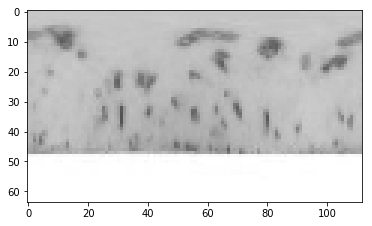

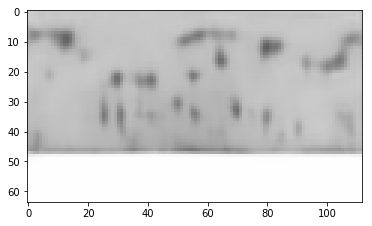

images/237.jpg


In [31]:
# Let's just view a few input images and output images

#test_images=all_directory_images_generator()

next_batch, next_filenames = next(test_images)
#next_batch = next(test_generator)
images = next_batch[0]
first_image=images[0]
second_image=images[1]

plt.imshow(get_image(first_image))
plt.show()

#plt.imshow(second_image)
#plt.show()

recreated_pill = autoencoder.predict(x=images,batch_size=32)

plt.imshow(get_image(recreated_pill[0]))
plt.show()
print(next_filenames[0])
#categories = next_batch[1]
#print(categories[0])

In [47]:
enc_model = Model(autoencoder.input, autoencoder.layers[2].output)


In [40]:
enc_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 52, 100, 1)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 52, 100, 64)       1664      
_________________________________________________________________
encoder (Conv2D)             (None, 52, 100, 16)       9232      
Total params: 10,896
Trainable params: 10,896
Non-trainable params: 0
_________________________________________________________________


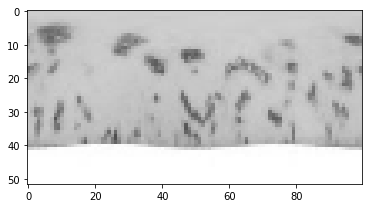

In [41]:
# See what our output looks like
# Let's just view a few input images and see results

next_batch = next(test_generator)
images = next_batch[0]
first_image=images[0]
second_image=images[1]

plt.imshow(get_image(first_image))
plt.show()

#plt.imshow(second_image)
#plt.show()

embeddings = enc_model.predict(x=images,batch_size=32)



In [42]:
#test_generator.filenames

In [43]:
embeddings.shape


(32, 52, 100, 16)

In [44]:
e = embeddings[0].flatten()
e

array([0.44578773, 0.6116289 , 0.4794868 , ..., 0.36802438, 0.33206958,
       0.4621178 ], dtype=float32)

In [45]:
enc_model.layers[-1].name

'encoder'

In [46]:

x = enc_model.get_layer('encoder').output
x = GlobalMaxPooling2D(name='flat')(x)
new_model = Model(enc_model.input, x)


#short_base = Model(base_model.get_layer('input_11').input, base_model.get_layer('avg_pool'))

Found 96 images belonging to 1 classes.


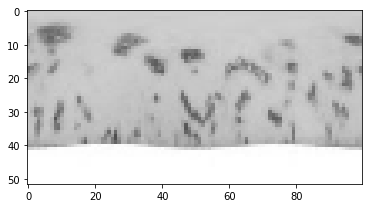

images/229.jpg


In [49]:
# See what our output looks like
# Let's just view a few input images and see results

mygen = all_directory_images_generator(batch_size=32)

next_images, next_filenames = next(mygen)
images = next_images[0]
first_image=images[0]
second_image=images[1]

plt.imshow(get_image(first_image))
plt.show()

#plt.imshow(second_image)
#plt.show()

embeddings2 = new_model.predict(x=images,batch_size=32)

print(next_filenames[0])


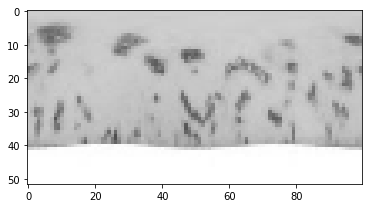

images/229.jpg


In [52]:
next_images, next_filenames = next(mygen)
images = next_images[0]
first_image=images[0]
second_image=images[1]

plt.imshow(get_image(first_image))
plt.show()

#plt.imshow(second_image)
#plt.show()

embeddings2 = new_model.predict(x=images,batch_size=32)

print(next_filenames[0])

In [273]:
# For confusion matrix, you need two items, y_test and y_pred
#     y_test is the known categorical values of the test set 
#     y_pred is the predicted categorical values of the test set 

# To get y_test we'll use the validation_generator, but let's grab all images
#test_generator.batch_size = 751

nb_batches_to_capture = 1 # batches * batch_size should be less than total number of items available, else repeats will happen

y_true = []
y_pred = []

for index in range(nb_batches_to_capture):
    next_batch = next(test_generator)
    #images = next_batch[0]
    #print(images[0])
    categories = next_batch[1]
    #print(categories[0])
    #print(len(categories))
    # To get y_pred, we actually need to predict the categories of the all_images set
    #predicted_categories= model.predict_classes(x=images,batch_size=batch_size)
    #print(len(predicted_categories))
    #if len(categories) == len(predicted_categories):
    #    y_true.extend(categories)
    #    y_pred.extend(predicted_categories)
    #else:
    #    print("Mismatched actual and predicted - ignoring batch")
    
print(len(y_true))
print(len(y_pred))

0
0


In [191]:
# Create methods for determining closest image
def retrieve_closest_elements(test_code, test_label, learned_codes):
    distances = []
    for code in learned_codes:
        distance = np.linalg.norm(code - test_code)
        distances.append(distance)
    nb_elements = learned_codes.shape[0]
    distances = np.array(distances)
    learned_code_index = np.arange(nb_elements)
    labels = np.copy(y_train).astype('float32')
    labels[labels != test_label] = -1
    labels[labels == test_label] = 1
    labels[labels == -1] = 0
    distance_with_labels = np.stack((distances, labels, learned_code_index), axis=-1)
    sorted_distance_with_labels = distance_with_labels[distance_with_labels[:, 0].argsort()]

    sorted_distances = 28 - sorted_distance_with_labels[:, 0]
    sorted_labels = sorted_distance_with_labels[:, 1]
    sorted_indexes = sorted_distance_with_labels[:, 2]
    return sorted_distances, sorted_labels, sorted_indexes


def compute_average_precision_score(test_codes, test_labels, learned_codes, n_samples):
    out_labels = []
    out_distances = []
    retrieved_elements_indexes = []
    for i in range(len(test_codes)):
        sorted_distances, sorted_labels, sorted_indexes = retrieve_closest_elements(test_codes[i], test_labels[i], learned_codes)
        out_distances.append(sorted_distances[:n_samples])
        out_labels.append(sorted_labels[:n_samples])
        retrieved_elements_indexes.append(sorted_indexes[:n_samples])

    out_labels = np.array(out_labels)
    out_labels_file_name = 'computed_data/out_labels_{}'.format(n_samples)
    np.save(out_labels_file_name, out_labels)

    out_distances_file_name = 'computed_data/out_distances_{}'.format(n_samples)
    out_distances = np.array(out_distances)
    np.save(out_distances_file_name, out_distances)
    score = label_ranking_average_precision_score(out_labels, out_distances)
    scores.append(score)
    return score


def retrieve_closest_images(test_element, test_label, n_samples=10):
    learned_codes = encoder.predict(x_train)
    learned_codes = learned_codes.reshape(learned_codes.shape[0],
                                          learned_codes.shape[1] * learned_codes.shape[2] * learned_codes.shape[3])

    test_code = encoder.predict(np.array([test_element]))
    test_code = test_code.reshape(test_code.shape[1] * test_code.shape[2] * test_code.shape[3])

    distances = []

    for code in learned_codes:
        distance = np.linalg.norm(code - test_code)
        distances.append(distance)
    nb_elements = learned_codes.shape[0]
    distances = np.array(distances)
    learned_code_index = np.arange(nb_elements)
    labels = np.copy(y_train).astype('float32')
    labels[labels != test_label] = -1
    labels[labels == test_label] = 1
    labels[labels == -1] = 0
    distance_with_labels = np.stack((distances, labels, learned_code_index), axis=-1)
    sorted_distance_with_labels = distance_with_labels[distance_with_labels[:, 0].argsort()]

    sorted_distances = 28 - sorted_distance_with_labels[:, 0]
    sorted_labels = sorted_distance_with_labels[:, 1]
    sorted_indexes = sorted_distance_with_labels[:, 2]
    kept_indexes = sorted_indexes[:n_samples]

    score = label_ranking_average_precision_score(np.array([sorted_labels[:n_samples]]), np.array([sorted_distances[:n_samples]]))

    print("Average precision ranking score for tested element is {}".format(score))

    original_image = x_test[0]
    cv2.imshow('original_image', original_image)
    retrieved_images = x_train[int(kept_indexes[0]), :]
    for i in range(1, n_samples):
        retrieved_images = np.hstack((retrieved_images, x_train[int(kept_indexes[i]), :]))
    cv2.imshow('Results', retrieved_images)
    #cv2.waitKey(0)

    cv2.imwrite('test_results/original_image.jpg', 255 * cv2.resize(original_image, (0,0), fx=3, fy=3))
    cv2.imwrite('test_results/retrieved_results.jpg', 255 * cv2.resize(retrieved_images, (0,0), fx=2, fy=2))



In [192]:
# Create methods to test the model
def test_model(n_test_samples, n_train_samples):
    learned_codes = encoder.predict(x_train)
    learned_codes = learned_codes.reshape(learned_codes.shape[0], learned_codes.shape[1] * learned_codes.shape[2] * learned_codes.shape[3])
    test_codes = encoder.predict(x_test)
    test_codes = test_codes.reshape(test_codes.shape[0], test_codes.shape[1] * test_codes.shape[2] * test_codes.shape[3])
    indexes = np.arange(len(y_test))
    np.random.shuffle(indexes)
    indexes = indexes[:n_test_samples]

    print('Start computing score for {} train samples'.format(n_train_samples))
    t1 = time.time()
    score = compute_average_precision_score(test_codes[indexes], y_test[indexes], learned_codes, n_train_samples)
    t2 = time.time()
    print('Score computed in: ', t2-t1)
    print('Model score:', score)


def plot_denoised_images():
    denoised_images = autoencoder.predict(x_test_noisy.reshape(x_test_noisy.shape[0], x_test_noisy.shape[1], x_test_noisy.shape[2], 1))
    test_img = x_test_noisy[0]
    resized_test_img = cv2.resize(test_img, (280, 280))
    #cv2.imshow('input', resized_test_img)
    #cv2.waitKey(0)
    output = denoised_images[0]
    resized_output = cv2.resize(output, (280, 280))
    #cv2.imshow('output', resized_output)
    #cv2.waitKey(0)
    cv2.imwrite('test_results/noisy_image.jpg', 255 * resized_test_img)
    cv2.imwrite('test_results/denoised_image.jpg', 255 * resized_output)


In [193]:

# To test the whole model
n_test_samples = 100
#n_train_samples = [10, 50, 100, 200, 300, 400, 500, 750, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000,
#                   20000, 30000, 40000, 50000, 60000]

n_train_samples = [10]

for n_train_sample in n_train_samples:
    test_model(n_test_samples, n_train_sample)








NameError: name 'x_train' is not defined

In [ ]:
# Save model
np.save('computed_data/scores', np.array(scores))

In [ ]:
# To retrieve closest image
retrieve_closest_images(x_test[0], y_test[0])


In [ ]:

# To plot a denoised image
plot_denoised_images()

In [ ]:
print('hello')